# Time Series Analysis And Forecastig For Stock Market

#  Download historical stock data from Alpha Vantage

In [1]:

import pandas as pd
import os

api_key = "your_alpha_vantage_key"
symbol = "AAPL"
url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={api_key}&datatype=csv"

df = pd.read_csv(url)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.sort_index()
print(df.head())
# Save locally
os.makedirs("data", exist_ok=True)
df.to_csv("data/stock_data.csv")


             open   high    low  close   volume
timestamp                                      
1999-11-01  80.00  80.69  77.37  77.62  2487300
1999-11-02  78.00  81.69  77.31  80.25  3564600
1999-11-03  81.62  83.25  81.00  81.50  2932700
1999-11-04  82.06  85.37  80.62  83.62  3384700
1999-11-05  84.62  88.37  84.00  88.31  3721500


# Preprocessing and Visualization

C:\Users\Pavithra\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


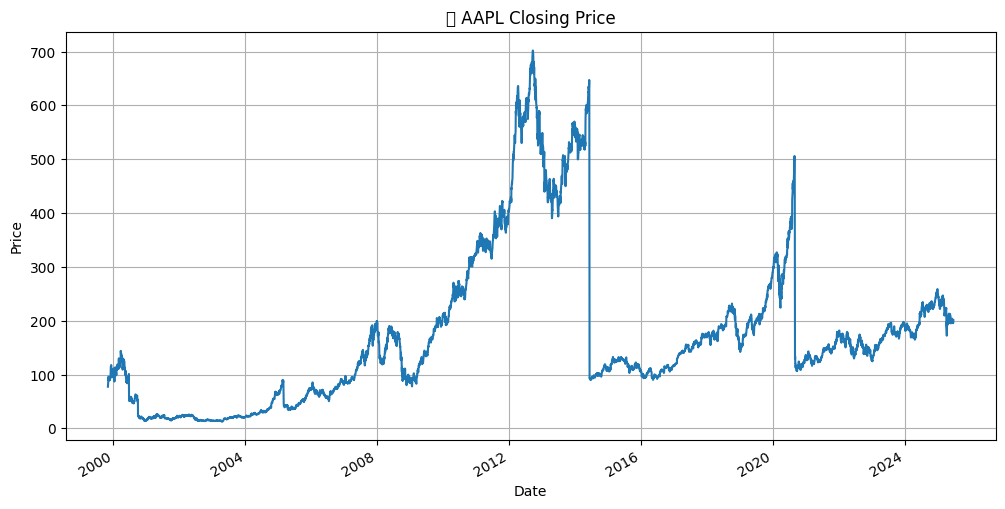

In [2]:
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("data/stock_data.csv", parse_dates=["timestamp"], index_col="timestamp")

# Plot closing price
data["close"].plot(figsize=(12, 6), title="📉 AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()


# ARIMA

C:\Users\Pavithra\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Pavithra\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Pavithra\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Pavithra\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Pavithra\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.w

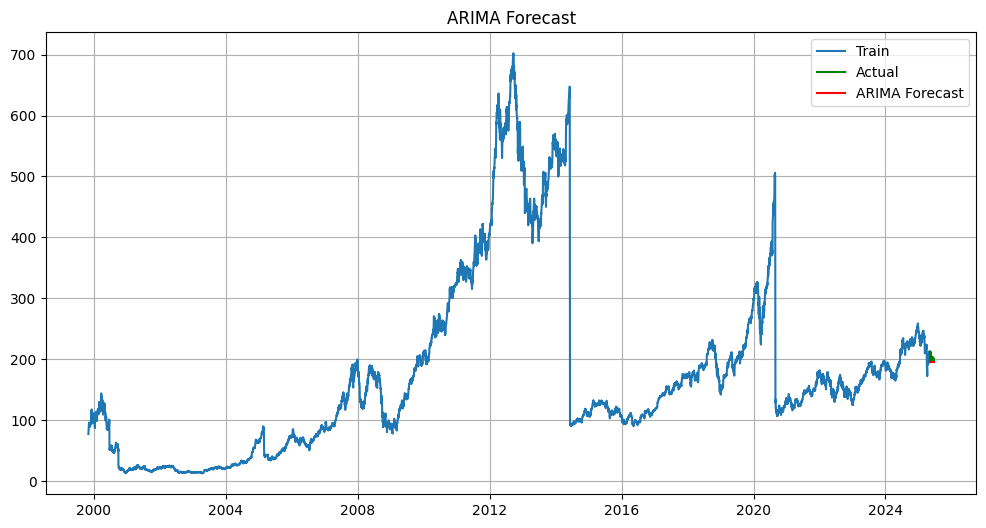

📊 ARIMA Evaluation:
RMSE: 64.04204666666665
MAE : 6.292666666666665


In [5]:
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_arima = data["close"][:-30]
test_arima = data["close"][-30:]

model_arima = auto_arima(train_arima, seasonal=False, stepwise=True)
forecast_arima = model_arima.predict(n_periods=30)

plt.figure(figsize=(12,6))
plt.plot(train_arima, label="Train")
plt.plot(test_arima, label="Actual", color="green")
plt.plot(test_arima.index, forecast_arima, label="ARIMA Forecast", color="red")
plt.title("ARIMA Forecast")
plt.legend()
plt.grid(True)
plt.show()

print("📊 ARIMA Evaluation:")
print("RMSE:", (mean_squared_error(test_arima, forecast_arima)))
print("MAE :", mean_absolute_error(test_arima, forecast_arima))


# Prophet

16:03:42 - cmdstanpy - INFO - Chain [1] start processing
16:03:54 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Pavithra\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


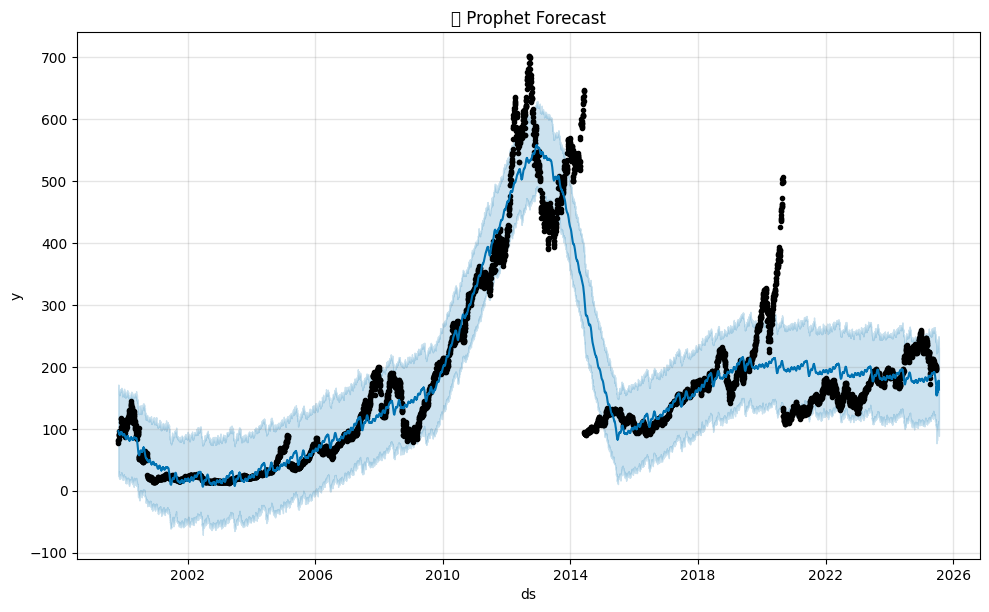

In [6]:
from prophet import Prophet

df_prophet = data.reset_index()[["timestamp", "close"]]
df_prophet.columns = ["ds", "y"]

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

model.plot(forecast)
plt.title("🔮 Prophet Forecast")
plt.grid(True)
plt.show()


# LSTM Model

C:\Users\Pavithra\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 86ms/step - loss: 0.0145
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - loss: 0.0018
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - loss: 0.0014
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step - loss: 0.0016
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 22s 107ms/step - loss: 0.0014
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


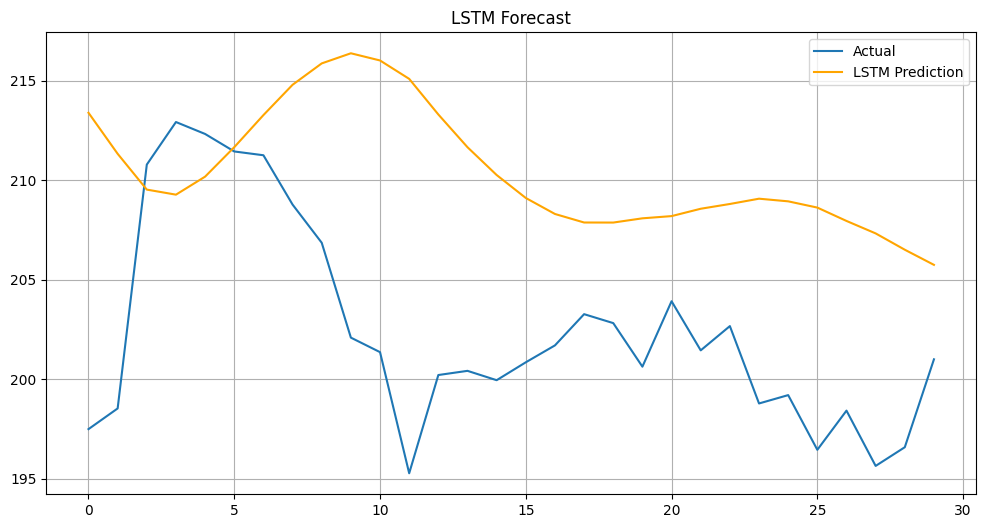

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Prepare data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data["close"].values.reshape(-1, 1))

X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)

# Predict next 30
inputs = scaled_data[-90:]
X_test = []
for i in range(60, 90):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test).reshape(30, 60, 1)

# ✅ Use correct model name here
predicted_lstm = model.predict(X_test)
predicted_lstm = scaler.inverse_transform(predicted_lstm)

# Compare with actual
actual_lstm = data["close"].values[-30:]

plt.figure(figsize=(12,6))
plt.plot(actual_lstm, label="Actual")
plt.plot(predicted_lstm, label="LSTM Prediction", color="orange")
plt.title("LSTM Forecast")
plt.legend()
plt.grid(True)
plt.show()


# Model Comparison

In [11]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# ✅ Evaluation function
def evaluate(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} Evaluation:")
    print(f"  ✅ RMSE: {rmse:.2f}")
    print(f"  ✅ MAE : {mae:.2f}\n")

# --------------------------
# ✅ Evaluate ARIMA
# --------------------------
# Ensure forecast_arima has 30 values (same as test_arima)
forecast_arima = model_arima.predict(n_periods=len(test_arima))
evaluate(test_arima, forecast_arima, "ARIMA")

# --------------------------
# ✅ Evaluate Prophet
# --------------------------
# Prophet actual and prediction (last 30 days)
model = Prophet()
model.fit(df_prophet)
future = model.make_future_dataframe(periods=30)
forecast_prophet = model.predict(future)

# Evaluation
actual_prophet = df_prophet["y"].values[-30:]
predicted_prophet = forecast_prophet["yhat"].values[-30:]
evaluate(actual_prophet, predicted_prophet, "Prophet")


# --------------------------
# ✅ Evaluate LSTM
# --------------------------
# Ensure shapes match: reshape predicted LSTM
actual_lstm = data["close"].values[-30:]
predicted_lstm = predicted_lstm.reshape(-1)  # from (30, 1) to (30,)
evaluate(actual_lstm, predicted_lstm, "LSTM")


C:\Users\Pavithra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Pavithra\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\Pavithra\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ARIMA Evaluation:
  ✅ RMSE: 8.00
  ✅ MAE : 6.29



19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:15 - cmdstanpy - INFO - Chain [1] done processing


Prophet Evaluation:
  ✅ RMSE: 36.03
  ✅ MAE : 34.63

LSTM Evaluation:
  ✅ RMSE: 9.65
  ✅ MAE : 8.47



# Final Evaluation & Web Deployment

In [12]:
import streamlit as st
import pandas as pd

# Load your dataset
data = pd.read_csv("data/stock_data.csv", parse_dates=["timestamp"], index_col="timestamp")

st.title("📈 Stock Forecast App")
st.subheader("Closing Price Trend")
st.line_chart(data["close"])


2025-06-24 19:23:20.163 
  command:

    streamlit run C:\Users\Pavithra\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator()

In [13]:
!pip install streamlit


In [14]:
streamlit run app.py


SyntaxError: invalid syntax (507122745.py, line 1)